<a href="https://colab.research.google.com/github/gduncan2/CS445_OpticalFlowProj/blob/main/445FinalProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
def play_video(video, fps):
    while (video.isOpened()):
        retval, frame = video.read()
        if retval:
            cv2.imshow("Video", frame)
            val = cv2.waitKey(int(1000/fps))
            if val == 27:
                break
        else:
            break
    video.release()
    cv2.destroyAllWindows()

def write_video(filename, frames, fps):
    output = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'XVID'), fps, (frames[0].shape[1], frames[0].shape[0]), True)
    for frame in frames:
        output.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    output.release()

def get_video_frames(video):
    frames = []
    while(video.isOpened()):
        retval, frame = video.read()
        if retval:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        else:
            break
    return frames

In [4]:
cv2.destroyAllWindows()

In [5]:
cv2.destroyAllWindows()
video = cv2.VideoCapture('./media/roadrunner.mp4')
frames = get_video_frames(video)
write_video("./outputs/roadrunner_restored.mp4", frames, 30)



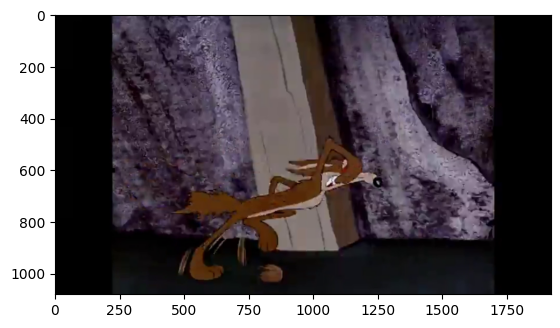

In [6]:
plt.imshow(frames[5])

In [8]:
def save_half_frames(frames):
    os.makedirs('./outputs/even_frames', exist_ok=True)
    os.makedirs('./outputs/odd_frames', exist_ok=True)

    even_frames = []
    odd_frames = []

    for i, frame in enumerate(frames):
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        if i % 2 == 0:
            even_frames.append(frame)
            cv2.imwrite(f"./outputs/even_frames/frame_{i:04d}.png", frame_bgr)
        else:
            odd_frames.append(frame)
            cv2.imwrite(f"./outputs/odd_frames/frame_{i:04d}.png", frame_bgr)

    print(f"Saved {len(even_frames)} even frames and {len(odd_frames)} odd frames.")

In [9]:
cv2.destroyAllWindows()
video = cv2.VideoCapture("./media/roadrunner.mp4")
frames = get_video_frames(video)
print(f"Number of frames extracted: {len(frames)}")
# save_half_frames(frames) # Saves the frames in the folders

Number of frames extracted: 291
Saved 146 even frames and 145 odd frames.


In [10]:
def load_saved_frames(folder):
    frame_files = sorted([f for f in os.listdir(folder) if f.endswith('.png')])
    loaded_frames = []

    for file in frame_files:
        path = os.path.join(folder, file)
        frame = cv2.imread(path)
        if frame is not None:
            loaded_frames.append(frame)

    print(f"Loaded {len(loaded_frames)} frames from '{folder}'")
    return loaded_frames

In [11]:
def compare_frames_opencv_only(even_frames, odd_frames):
    comparisons = min(len(odd_frames), len(even_frames) - 1)

    for i in range(comparisons):
        prev_even = even_frames[i]
        next_even = even_frames[i + 1]
        target_odd = odd_frames[i]

        interpolated = cv2.addWeighted(prev_even, 0.5, next_even, 0.5, 0)

        diff = cv2.absdiff(interpolated, target_odd)
        diff_mean = cv2.mean(diff)[:3]

        interp_rgb = cv2.cvtColor(interpolated, cv2.COLOR_BGR2RGB)
        target_rgb = cv2.cvtColor(target_odd, cv2.COLOR_BGR2RGB)
        diff_rgb = cv2.cvtColor(diff, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Comparison #{i+1} — Mean Abs Diff (BGR): {diff_mean}")

        plt.subplot(1, 3, 1)
        plt.imshow(interp_rgb)
        plt.title("Interpolated (Even Avg)")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(target_rgb)
        plt.title("Ground Truth (Odd)")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(diff_rgb)
        plt.title("Difference")
        plt.axis('off')

        plt.show()

        # Remove to see all frames:
        break

Loaded 146 frames from './outputs/even_frames'
Loaded 145 frames from './outputs/odd_frames'


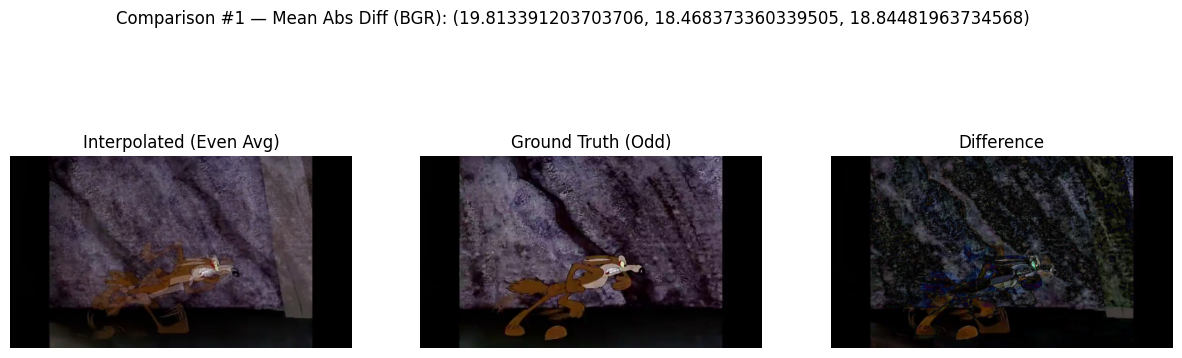

In [12]:
even_frames = load_saved_frames('./outputs/even_frames')
odd_frames = load_saved_frames('./outputs/odd_frames')

compare_frames_opencv_only(even_frames, odd_frames)